In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

C:\Users\havva\AppData\Local\Temp\ipykernel_5868\3296636811.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
filterwarnings ('ignore') # bazı warningleri ignore etme 
pd.set_option('display.max_columns', None)   # bütün sütunları göster 
pd.set_option('display.width', 200)   # max genişlik ayarı
pd.set_option('display.float_format', lambda x: '%.2f' % x) # virgülden sonra iki basamak göster

# METİN ÖN İŞLEME # 

Veri setinde problemli olarak kabul edilecek durumlardan kurtulunur. Bir metinde çıkarılması gereken yapılar ortadan kaldırılır.

In [3]:
df = pd.read_csv("amazon_reviews.csv") # veri setini okuma

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


# bu veri seti bir ürüne yapılan yorumları ifade eder

- reviewerID : yorum yapan kişiler
- asin : ürün 
- helpful : yorumların faydalı olup olmadığına ilişkin değişken
- reviewText : yorumlar, *odaklanacağımız değişken*
- overall : ürüne verilen puan 
- summary : yorumların özeti 
- helpful_yes,total_vote : helpful'un açılmış hali


In [5]:
df['reviewText']  

0                                              No issues.
1       Purchased this for my device, it worked as adv...
2       it works as expected. I should have sprung for...
3       This think has worked out great.Had a diff. br...
4       Bought it with Retail Packaging, arrived legit...
                              ...                        
4910    I bought this Sandisk 16GB Class 10 to use wit...
4911    Used this for extending the capabilities of my...
4912    Great card that is very fast and reliable. It ...
4913    Good amount of space for the stuff I want to d...
4914    I've heard bad things about this 64gb Micro SD...
Name: reviewText, Length: 4915, dtype: object

In [6]:
# verilerde bazı hafrkler büyük bazı harfler küçük, belirli bir standarta koyulmalı
# Normalizing Case Folding
###

df ['reviewText'] = df['reviewText'].str.lower()
# bütün kelimeler küçük harfle yazdır çünkü aynı kelime büyük harfle başlasaydı o kelime metinde aranmak istenince bulunamazdı 
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

# metinde işimize yarmayacak, bizim için bir anlam içermeyen ifadeler silinmeli

# regular expression (regex)  
metinde belirli bir örüntüyü yakalayıp üzerinde çalışmak için kullanılan bir yapıdır

In [7]:
# REMOVE PUNCTUATIONS # noktalam işaretinin az çok olması bir anlam ifade etmez 

import re # regex
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub("[^\w\s]","", str(x)))
# metinde noktalama işareti yerine boşluk eklenir 

df['reviewText']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

In [8]:
# REMOVE NUMBERS # bazı metinlerde rakamlar anlam ifade edebilir, bu veri için gerekli değil

df['reviewText'] = df['reviewText'].fillna('').apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df["reviewText"] 

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

In [9]:
# REMOVE STOP WORDS # metinde herhangi bir anlamı olmayan ama dilde kullanılan yaygın kelimeler: bağlaçlar, zamirler vb. (for, is, of) bu gibi ifadelerin dilde ölçümsel bir anlamı yoktur
import nltk 
nltk.download('stopwords') # nltk kütüphanesi içinde ingilizce dili için stopwords listesi indirilir, türkçe dili içinde benzer çalışmlar 

sw = stopwords.words('english') # bu kelimler sw içerisine aktarılır 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
sw # kendi setimizi de oluşturabiliriz

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
# bütün satırları gezip bütün kelimelere ulaşmalıyız, apply df içinde bütün satırları gezme için 

# REMOVE STOPWORD # 

df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

# x : gelen satır ifadesi
# gelen satır stringe çevrilir ve boşluğa göre split edilerek ayırlır, elde edilen kelime sw içerisinde değilse o kelimeyi al ve kaldır 
df["reviewText"]

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [12]:
# RARE WORDS # nadir olan kelimeleri çıkarabiliz veri setinden 

# bütün kelimlerin kaçar defa geçtiğini bulup belli bir sayıya gmre nadir geçenleri kaldırabiliriz

temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts() # bütün kelimleri saydırıyoruz ve geçici dataframe aktarıyoruz
temp_df

card          4603
gb            1725
phone         1685
works         1559
great         1445
              ... 
sharper          1
cheapos          1
gate             1
measuring        1
stealwould       1
Name: count, Length: 9701, dtype: int64

In [13]:
drops = temp_df[temp_df <= 1] # 1den az frekanslıları seçip dropsa atıyoruz
drops

conclusionmy       1
mbsbuy             1
flimsier           1
disappointedtry    1
priceokay          1
                  ..
sharper            1
cheapos            1
gate               1
measuring          1
stealwould         1
Name: count, Length: 5612, dtype: int64

In [14]:
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops)) # dropsta yer alanlar boşluk ile yer değiştirilir
df["reviewText"]

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected higher capacity think made bit ...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used capabilities samsung galaxy note greatly ...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [15]:
# TOKENIZATION # cümleleri tokenlarına ayırma yani parçalama, birimleştirme işlemini programatik hale getirmek 

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df["reviewText"].apply(lambda x: TextBlob(x).words).head() # TextBlob metodu çalıştıırıldıktan sonra kelimler gelsin 

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [17]:
# LEMMATIZATION # kelimleri köklerine ayırmak / literatürde stemming işlemi de kullanılır köklerine ayırmak için 
# en: kelimelerin sonlarındaki -s takılarını ortadan kaldırma , tr: gözlük, gözlükçü => göz

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # bütün kelimleri köklerine ayırır
df['reviewText']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# METİN GÖRSELLEŞTİRME # 



In [19]:
# Metinler öncelikle sayısal hale getirilmeli. Bu yüzden kelimelerin frekansları çıkarılmalı.
tf = df['reviewText'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"] # sütun başlıkları ekleme 
tf

,words,tf
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00
...,...,...
3683,pureview,3.00
3684,laptoptablet,2.00
3685,employee,2.00
3686,sandisksequential,2.00


In [20]:
tf.sort_values("tf", ascending=False) # büyükten küçüğe sıralandı

,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


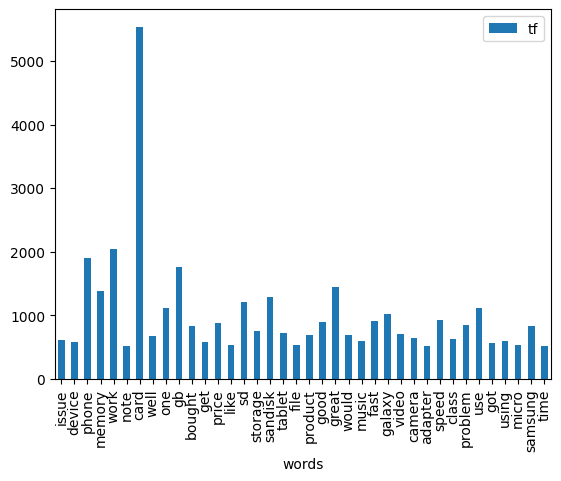

In [21]:
# SÜTUN GRAFİK (BART PLOT)
# 3687 tane verinin grafiğini çizdirmek mantıklı olmaz bu yüzden belli bir şarta göre veri seçeceğiz

tf[tf["tf"] > 500].plot.bar(x="words", y="tf") # frekansı 500'den büyük kelimelerin sütun grafiği çizilir
plt.show()
# bu kelimlere bakılarak ürünün ne olduğuna karar verilebilir 
# overall kullanılarak buralara gelserydik düşük puan içerenlerde hangi kelimeler daha çok kullanılmış diye bakabilirdik ve veri setini buna göre filtreleyebilirdik # ürünle ilgili en dikkat çeken yorumnlar elde edilebilirdi #

In [22]:
# KELİM BULUT (WORD CLOUD) # bir çok özellik taşır 
# kelimelerin frekanslarına göre bir bulut şeklinde görsel oluşturulması

# bütün satırları gezerek tek bir cümle gibi birleştirmeliyiz
text = " ".join(i for i in df.reviewText)
text

'issue purchased device worked advertised never much phone memory since download lot stuff brainer work expected higher capacity think made bit earlier version paint look clean think worked gb card went south one held pretty well since note update ive month zero issue since transferred note note card reliable bought retail packaging arrived legit envelope version asian like picture show arrived quickly bought retail packaging htc one lg optimus card working order probably best price youll get nice sd card mini storage doesnt anything else supposed purchased add additional storage microsoft surface pro tablet come gb supposed sandisk long standing reputation speaks phone never skip beat file transfer speedy corruption issue memory issue would expect sandisk brand great card precious file slightly cheaper piece crap lose everything spending extra couple buck trusted product go good qa hard believe affordable digital become gb device one quarter postage stamp would le generation picked po

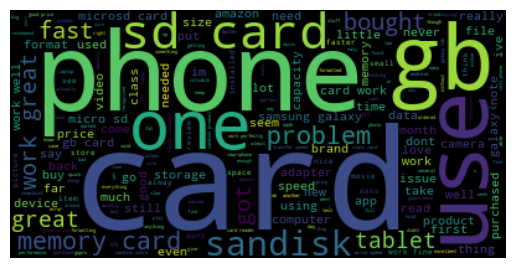

In [23]:
wordCloud = WordCloud().generate(text)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# frekansı büyük olan kelimiler büyük halde olur, frekansları kendi hesaplar
# WordCloud() içerisinde daha farklı özellikler yer alır 

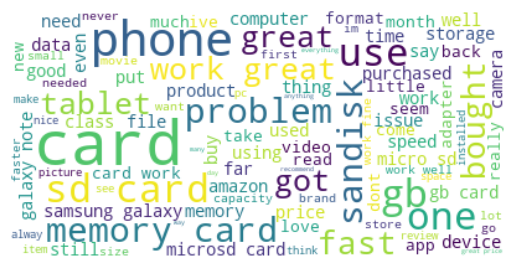

In [24]:
wordcloud = WordCloud(max_font_size=50,max_words=100,background_color="white").generate (text)
# yukarıdaki gibi belirli formata göre de wordcloud oluşturabiliriz 
plt.figure()
plt.imshow (wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# wordcloud.to_file("wordcloud.png") # kaydedilir

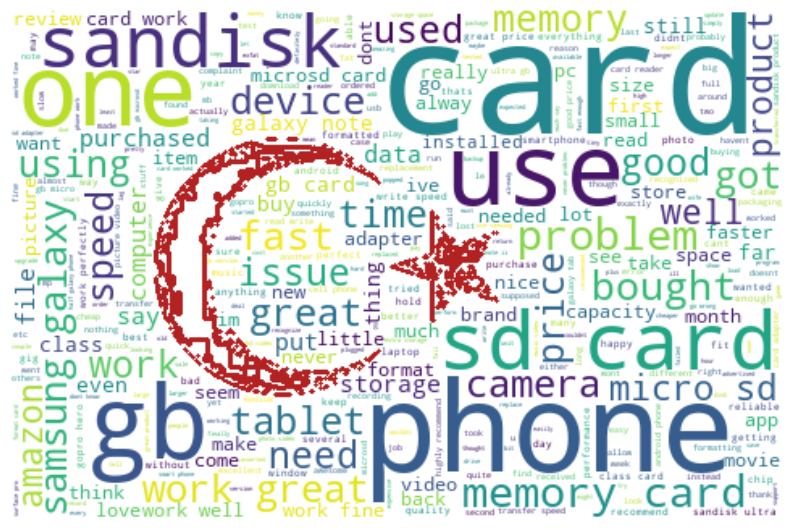

In [25]:
# ŞABLONA GÖRE KELİME BULUTU OLUŞTURMA # 
# bir wordcloud u belirli bir resme yedirmek istiyoruz, kelimleri şablon resimle birleştiricez

tr_mask = np.array(Image.open("tr.png")) # şablon resmi aldık

wc = WordCloud (background_color="white", max_words=1000, mask=tr_mask, contour_width=3, contour_color="firebrick")
wc.generate(text)
# şablon ile birlikte wordcloud u birleştirdik
plt.figure(figsize=[10, 10])
plt.imshow (wc, interpolation="bilinear")
plt.axis ("off")
plt.show()

# marakara ilişkin kelimle bulutları bu şekilde oluşturularak reklamlar yapılabilir

# SENTİMENT MODELLEMESİ # 

Elimizde bulunana metinlerin duygu analizi yapılacak.

In [28]:
df["reviewText"].head()   # "device" kelimesi nötr anlam taşır, "never" pozitif anlam taşımaz

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [29]:
# bir liste sayesinde kelimelerin pozitif mi negatif mi olduğuna karar verilir 

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...


True

In [34]:
sia = SentimentIntensityAnalyzer() # bu model sayesinde pozitif negatif skorları getirilir
sia.polarity_scores("The film was awesome") # 'compound': 0.6249  / pozitif duygu ağır basar
# cümlenin pozitif negatif skorları elde edilir, skorlar 1 ile -1 arasında olur 
# 'compound' ifadesi 0'dan büyükse pozitif bir anlam çıkarılır, 0'dan küçükse negatif bir anlam çıkarılır

sia.polarity_scores("I like this music but it is not good as the other one") # 'compound': -0.3311 / negatif duygu ağır basar

{'neg': 0.209, 'neu': 0.673, 'pos': 0.118, 'compound': -0.3311}

In [36]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)) # 10 tane cümlenin duygu skorlarını elde ettik 
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)['compound']) # sadece 'compound' değertlerini elde ettik

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.87
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [37]:
df["polarity_scores"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)['compound']) # df'de yeni bir sütuna skorlar atandı

In [38]:
df.head()
# "polarity_scores" sütunu ve "overall" sütunu kullanılarak veri setindeki tezatlıklara ulaşılabilir. Örneğin "overall" değeri düşük ama "polarity_scores" yüksekse yapılan yorumda bir tezatlık olduğu anlaşılabilir.

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


In [45]:
# "polarity_scores" sütunu ve "overall" sütunu kullanılarak veri setindeki tezatlıklara ulaşılabilir. 
#  Örneğin "overall" değeri 3'ten büyük ama "polarity_scores" değeri 0'dan küçükse yapılan yorumda bir tezatlık olduğu anlaşılabilir.
tf = df[df["overall"] > 3 ] 
tf[tf["polarity_scores"] < 0] # 436 yorumda tezatlık var 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores
19,A2ELBSIZ26GKM2,B007WTAJTO,Aaron,"[0, 0]",work video stuttering like gb blah blah blah b...,5.00,works,1389052800,2014-07-01,160,0,0,-0.34
20,A6AL9BZ0JALUP,B007WTAJTO,Aaron,"[0, 0]",work expected high transfer speed nice extra m...,5.00,Works,1382832000,2013-10-27,407,0,0,-0.15
24,A243XIFG20QRQW,B007WTAJTO,Aaron Nash,"[0, 0]",san disk hard beat pay brand get quality produ...,5.00,Perfect,1395532800,2014-03-23,260,0,0,-0.20
34,A747BB4QM2SWW,B007WTAJTO,A. Bell,"[0, 0]",ive got couple varying size ive problem compla...,5.00,several sizes. zero issues.,1376784000,2013-08-18,477,0,0,-0.72
36,A2OP1LOKO6P5W4,B007WTAJTO,Abe The Babe,"[0, 0]",bought surface pro ive month ive problem fast ...,5.00,Works great!,1375142400,2013-07-30,496,0,0,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864,A3K8V7WFKJBQWG,B007WTAJTO,"xendula ""avid e-Book reader""","[0, 0]",constant use samsung ativ since january proble...,5.00,Constant use since January '13 - going strong,1385337600,2013-11-25,378,0,0,-0.40
4868,A1OTC0E0KG0TYH,B007WTAJTO,Xpolicy,"[0, 0]",problem use samsung note little slow writing m...,4.00,No Problem,1396310400,2014-01-04,338,0,0,-0.40
4886,A2IJ276VBT3V7S,B007WTAJTO,Yvonne M. Bennett,"[0, 0]",purchased tablet hold lot information problem,5.00,Works well,1396569600,2014-04-04,248,0,0,-0.40
4898,A3RR7N0Y5OPRNF,B007WTAJTO,Z. Duncan,"[0, 0]",im using point shoot camera never ever run spa...,5.00,Bigger is always better,1391385600,2014-03-02,281,0,0,-0.34
